In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
from xopt import Xopt
import yaml

# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")

YAML = """
xopt:
    dump_file: dump.yaml
generator:
    name: bayesian_exploration

evaluator:
    function: xopt.resources.test_functions.tnk.evaluate_TNK

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    constants: {a: dummy_constant}

"""
yaml_output = yaml.safe_load(YAML)

In [2]:
X = Xopt(config=yaml_output)

# for testing purposes only
if SMOKE_TEST:
    X.generator.numerical_optimizer.n_restarts = 1
    X.generator.n_monte_carlo_samples = 1

X


            Xopt
________________________________
Version: 1.4.0+6.g2a95b36.dirty
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: false, dump_file: dump.yaml, max_evaluations: null}
generator:
  name: bayesian_exploration
  supports_batch_generation: true
  optimization_options: {raw_samples: 20, num_restarts: 20, sequential: true, max_travel_distances: null,
    use_turbo: false}
  model: null
  turbo_state: null
  use_cuda: false
  model_constructor:
    name: standard
    use_low_noise_prior: true
    covar_modules: {}
    mean_modules: {}
    dtype: torch.float64
    device: cpu
  acquisition_options: {proximal_lengthscales: null, use_transformed_proximal_weights: true,
    monte_carlo_samples: 128}
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 1
  function_kwargs: {sleep: 0, random_sleep: 0, raise_probability: 0}
  vectorized: false
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_TH

In [3]:
X.random_evaluate(5)

for i in range(5):
    print(f"step {i}")
    X.step()

step 0
step 1
step 2
step 3
step 4


In [4]:
print(X.data)

          x1        x2               a        y1        y2         c1   
1   1.048688  0.633707  dummy_constant  1.048688  0.633707   0.575998  \
2   2.722498  0.276086  dummy_constant  2.722498  0.276086   6.492837   
3   2.067944  2.658495  dummy_constant  2.067944  2.658495  10.384587   
4   0.845944  1.027532  dummy_constant  0.845944  1.027532   0.768963   
5   0.659550  2.979759  dummy_constant  0.659550  2.979759   8.408121   
6   0.498836  0.173191  dummy_constant  0.498836  0.173191  -0.780431   
7   2.427090  2.395057  dummy_constant  2.427090  2.395057  10.527631   
8   0.991935  0.541497  dummy_constant  0.991935  0.541497   0.291212   
9   1.005654  0.450366  dummy_constant  1.005654  0.450366   0.124284   
10  0.094085  2.831061  dummy_constant  0.094085  2.831061   6.937557   

          c2 some_array  xopt_runtime  xopt_error  
1   0.318936  [1, 2, 3]      0.000029       False  
2   4.989633  [1, 2, 3]      0.000008       False  
3   7.117551  [1, 2, 3]      0.000006   

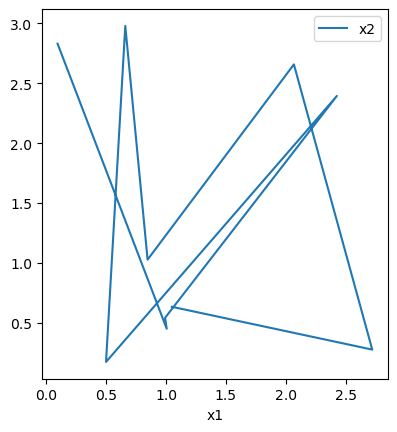

In [5]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")

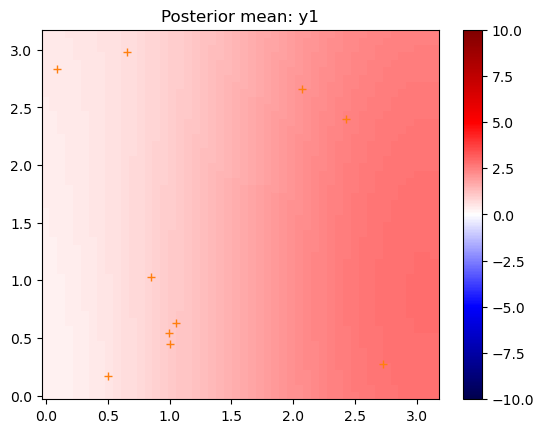

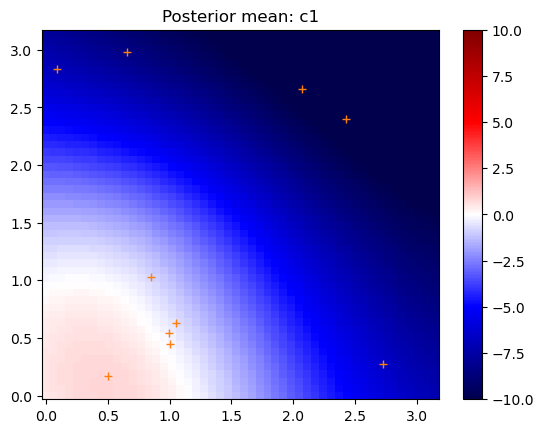

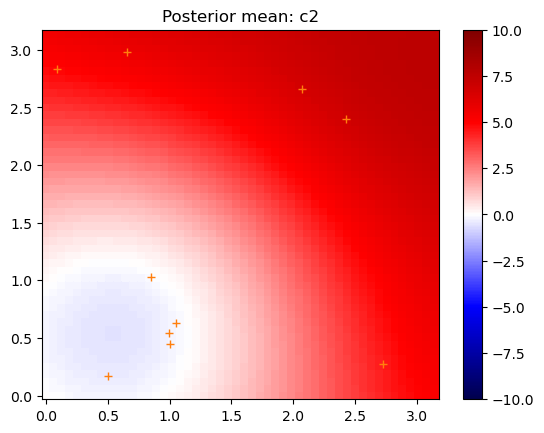

In [6]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh
n = 50
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = X.generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    for i in range(len(X.vocs.output_names)):
        mean = post.mean[...,i]
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax.pcolor(
            xx, yy, mean.squeeze().reshape(n, n),
            cmap="seismic",
            vmin=-10.0,
            vmax=10.0)
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

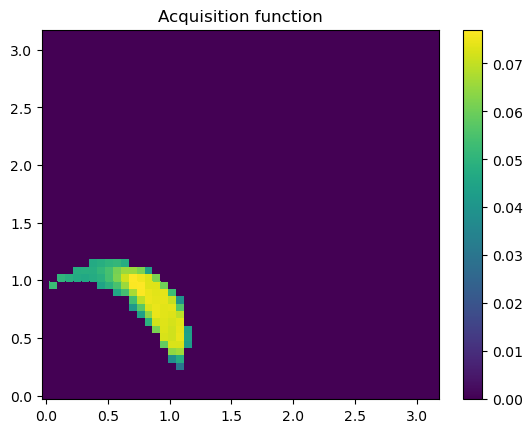

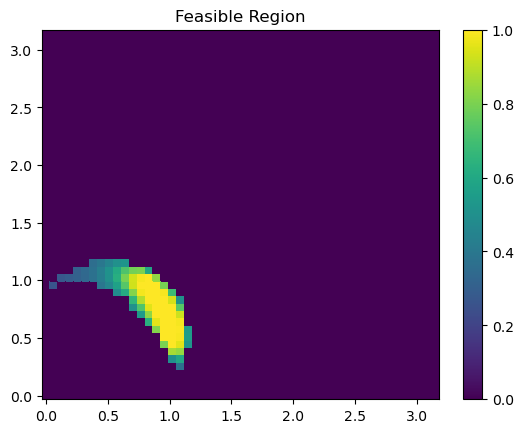

In [7]:
from xopt.generators.bayesian.objectives import feasibility

acq_func = X.generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n))
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    feas = feasibility(pts.unsqueeze(1), model, X.vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title("Feasible Region")